# readme
descrip: plot total, mean and eddy fluxes <br> 

update history: <br>
v1.0 DL 2021Feb06 <br>
v1.1 DL 2021Mar03 <br>
v1.2 DL 2021Apr24 <br>
v1.3 DL 2021May06 make publication-ready pics <br>
v1.4 DL 2021May20 combine TR run results into one fig (for main text) and control run results into one fig (support info) <br>
v1.5 DL 2021Jun02 pivot to CESM-HR special volume paper, use TR minus CN to account for the model drift <br>
 
extra notes: <br>
steps: <br>
1. finalize UET+VNT depth integration plot
2. interp temp from T grids to U grids 
3. compute 

# import modules

In [1]:
# general python packages
import numpy as np
# from scipy import stats
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
%matplotlib inline
import proplot as plot
import cartopy
# import cartopy.crs as ccrs
cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
# from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from mpl_toolkits.axes_grid1 import AxesGrid
import glob

# python GCM(POP) packages
import xgcm
import pop_tools
# import xoak
# import xesmf as xe

# dask jupyter lab packages
from dask.distributed import Client
# from dask.distributed import performance_report

# file name with time packages
# from itertools import product
# from cftime import DatetimeNoLeap

from tqdm import tqdm

# incorporate dask 

In [2]:
client = Client("tcp://10.73.2.215:37136")
client

<Client: 'tcp://10.73.2.215:37136' processes=16 threads=16, memory=316.64 GiB>

# define parameters

In [3]:
# === r: region (US east coast excluding Gulf of Mexico) ===
# reference: Plot2FindGulfMexicoYucatanChannelFLstraitnlatnlonIndex_2021Jul20.ipynb
nlon1_r_t12, nlon2_r_t12 = 200+50, 700-50 
nlat1_r_t12, nlat2_r_t12 = 1300+100, 2000-100

lon1_r, lon2_r = -85, -50
lat1_r, lat2_r = 25, 55

chunks_HR = {'nlat':400,'nlon':400}
# chunks_HR = {'time': 1}
# chunks_LR = {'nlat':384,'nlon':320/5,'z_t':1}
# ===========================================================

In [4]:
# read U, V vel TH 

# --- read one file ---
# infile_uet_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UET/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.UET.200601-200612.nc')
# ds_uet_TH = xr.open_dataset(infile_uet_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_uet_TH

# infile_vnt_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VNT/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.VNT.200601-200612.nc')
# ds_vnt_TH = xr.open_dataset(infile_vnt_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_vnt_TH
# ---------------------


# example file: 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_TH = np.arange(2001,2005+1) 
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_uet_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UET/')
infiles1a_uet_TH = [indir1a_uet_TH + prefix1a_TH + 'UET.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_uet_TH

# indir1a_vnt_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/VNT/')
# infiles1a_vnt_TH = [indir1a_vnt_TH + prefix1a_TH + 'VNT.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
#                for iyr in yrs1a_TH]
# infiles1a_vnt_TH


yrs2_TH = np.arange(2006,2100+1)
prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_uet_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UET/')
infiles2_uet_TH = [indir1b_uet_TH + prefix2_TH + 'UET.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_uet_TH

# indir1b_vnt_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VNT/')
# infiles2_vnt_TH = [indir1b_vnt_TH + prefix2_TH + 'VNT.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
#                for iyr in yrs2_TH]
# infiles2_vnt_TH

ds_uet_TH = xr.open_mfdataset(infiles1a_uet_TH + infiles2_uet_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

# ds_vnt_TH = xr.open_mfdataset(infiles1a_vnt_TH + infiles2_vnt_TH, compat="override", combine="by_coords", 
#                                data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_uet_TH first time: ', ds_uet_TH.time[0].values)
print('ds_uet_TH end time: ', ds_uet_TH.time[-1].values)
print('ds_uet_TH # time: ', len(ds_uet_TH.time))
#ds_vnt_TH

ds_uet_TH first time:  2001-02-01 00:00:00
ds_uet_TH end time:  2101-01-01 00:00:00
ds_uet_TH # time:  1200


In [5]:
indir1a_ues_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UES/')
infiles1a_ues_TH = [indir1a_ues_TH + prefix1a_TH + 'UES.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_ues_TH

indir1b_ues_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UES/')
infiles2_ues_TH = [indir1b_ues_TH + prefix2_TH + 'UES.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_ues_TH

ds_ues_TH = xr.open_mfdataset(infiles1a_ues_TH + infiles2_ues_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_ues_TH first time: ', ds_ues_TH.time[0].values)
print('ds_ues_TH end time: ', ds_ues_TH.time[-1].values)
print('ds_ues_TH # time: ', len(ds_ues_TH.time))

ds_ues_TH first time:  2001-02-01 00:00:00
ds_ues_TH end time:  2101-01-01 00:00:00
ds_ues_TH # time:  1200


In [6]:
# read U, V vel TH 

# --- read one file ---
# infile_uvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UVEL/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.UVEL.200601-200612.nc')
# ds_uvel_TH = xr.open_dataset(infile_uvel_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_uvel_TH

# infile_vvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VVEL/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.VVEL.200601-200612.nc')
# ds_vvel_TH = xr.open_dataset(infile_vvel_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_vvel_TH
# ---------------------


# example file: 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_TH = np.arange(2001,2005+1) 
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_uvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/UVEL/')
infiles1a_uvel_TH = [indir1a_uvel_TH + prefix1a_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_uvel_TH

indir1a_vvel_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/VVEL/')
infiles1a_vvel_TH = [indir1a_vvel_TH + prefix1a_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_vvel_TH


yrs2_TH = np.arange(2006,2100+1)
prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_uvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/UVEL/')
infiles2_uvel_TH = [indir1b_uvel_TH + prefix2_TH + 'UVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_uvel_TH

indir1b_vvel_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/VVEL/')
infiles2_vvel_TH = [indir1b_vvel_TH + prefix2_TH + 'VVEL.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_vvel_TH


ds_uvel_TH = xr.open_mfdataset(infiles1a_uvel_TH + infiles2_uvel_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

# ds_vvel_TH = xr.open_mfdataset(infiles1a_vvel_TH + infiles2_vvel_TH, compat="override", combine="by_coords", 
#                                data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_uvel_TH first time: ', ds_uvel_TH.time[0].values)
print('ds_uvel_TH end time: ', ds_uvel_TH.time[-1].values)
print('ds_uvel_TH # time: ', len(ds_uvel_TH.time))
#ds_vvel_TH

ds_uvel_TH first time:  2001-02-01 00:00:00
ds_uvel_TH end time:  2101-01-01 00:00:00
ds_uvel_TH # time:  1200


In [7]:
# read TEMP, SALT TH 

# --- read one file ---
# infile_temp_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/TEMP/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.TEMP.200601-200612.nc')
# ds_temp_TH = xr.open_dataset(infile_temp_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_temp_TH

# infile_salt_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/SALT/'
#                   'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.SALT.200601-200612.nc')
# ds_salt_TH = xr.open_dataset(infile_salt_TH, chunks={'nlat':400, 'nlon':300, 'z_t':1})
# ds_salt_TH
# ---------------------


# example file: 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.TEMP.192801-192812.nc'
yrs1a_TH = np.arange(2001,2005+1) 
prefix1a_TH = 'B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway.pop.h.'

indir1a_temp_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/TEMP/')
infiles1a_temp_TH = [indir1a_temp_TH + prefix1a_TH + 'TEMP.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_temp_TH

indir1a_salt_TH = ('/ihesp/archive/B.E.13.BHISTC5.ne120_t12.sehires38.003.sunway/ocn/proc/tseries/month_1/SALT/')
infiles1a_salt_TH = [indir1a_salt_TH + prefix1a_TH + 'SALT.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs1a_TH]
infiles1a_salt_TH


yrs2_TH = np.arange(2006,2100+1)
prefix2_TH = 'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.'
indir1b_temp_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/TEMP/')
infiles2_temp_TH = [indir1b_temp_TH + prefix2_TH + 'TEMP.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_temp_TH

indir1b_salt_TH = ('/ihesp/archive/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/SALT/')
infiles2_salt_TH = [indir1b_salt_TH + prefix2_TH + 'SALT.' + str(iyr) + '01-' + str(iyr) + '12.nc' 
               for iyr in yrs2_TH]
infiles2_salt_TH


ds_temp_TH = xr.open_mfdataset(infiles1a_temp_TH + infiles2_temp_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

ds_salt_TH = xr.open_mfdataset(infiles1a_salt_TH + infiles2_salt_TH, compat="override", combine="by_coords", 
                               data_vars="minimal", coords="minimal", chunks=chunks_HR, parallel=True)

print('ds_salt_TH first time: ', ds_salt_TH.time[0].values)
print('ds_salt_TH end time: ', ds_salt_TH.time[-1].values)
print('ds_salt_TH # time: ', len(ds_salt_TH.time))
#ds_salt_TH

ds_salt_TH first time:  2001-02-01 00:00:00
ds_salt_TH end time:  2101-01-01 00:00:00
ds_salt_TH # time:  1200


In [8]:
# supplimentary files 
# infile_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
#               'POPgrids_tx0.1v2_2020Jun29.nc') # POP t12 grid file
# ds_t12 = xr.open_dataset(infile_t12)
# ds_t12

infile_3dDZT_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
                    '3dDZT_SY_2021Nov04.nc') 
ds_3dDZT_t12 = xr.open_dataset(infile_3dDZT_t12)
ds_3dDZT_t12

infile_3dDZU_t12 = ('/ihesp/user/dapengli/Projects4iHESP/SupplementaryFiles4POP/POP_grids_2021Nov01/'
                    '3dDZU_SY_2021Nov04.nc') 
ds_3dDZU_t12 = xr.open_dataset(infile_3dDZU_t12)
ds_3dDZU_t12

# ds_r_t12 = ds_t12.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), 
#                        nlat=slice(nlat1_r_t12, nlat2_r_t12))

<xarray.Dataset>
Dimensions:  (nlat: 2400, nlon: 3600, z_t: 62)
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    DZU      (z_t, nlat, nlon) float64 ...

# data analysis

In [9]:
# make TH time coordinate consistent across different ds, otherwise xarray data array subtraction does not work 
print(ds_uvel_TH.time[0].values, ds_uvel_TH.time[-1].values, len(ds_uvel_TH.time)) 
# print(ds_vvel_TH.time[0].values, ds_vvel_TH.time[-1].values, len(ds_vvel_TH.time)) 
print(ds_temp_TH.time[0].values, ds_temp_TH.time[-1].values, len(ds_temp_TH.time)) 
print(ds_salt_TH.time[0].values, ds_salt_TH.time[-1].values, len(ds_salt_TH.time)) 
print(ds_uet_TH.time[0].values, ds_uet_TH.time[-1].values, len(ds_uet_TH.time)) 
print(ds_ues_TH.time[0].values, ds_ues_TH.time[-1].values, len(ds_ues_TH.time)) 

time_uvel_s_TH = ds_uvel_TH.time.to_pandas().index.shift(-1,'D') # shift it one month back 
# ds_uet_TH = ds_uet_TH_raw.assign_coords(time=time_hdift_s_TL).sel(time=slice('2001','2100'))

ds_uvel_TH = ds_uvel_TH.assign_coords(time=time_uvel_s_TH)
# ds_vvel_TH = ds_vvel_TH.assign_coords(time=time_uvel_s_TH)
ds_temp_TH = ds_temp_TH.assign_coords(time=time_uvel_s_TH)
ds_salt_TH = ds_salt_TH.assign_coords(time=time_uvel_s_TH)
ds_uet_TH = ds_uet_TH.assign_coords(time=time_uvel_s_TH)
ds_ues_TH = ds_ues_TH.assign_coords(time=time_uvel_s_TH)

2001-02-01 00:00:00 2101-01-01 00:00:00 1200
2001-02-01 00:00:00 2101-01-01 00:00:00 1200
2001-02-01 00:00:00 2101-01-01 00:00:00 1200
2001-02-01 00:00:00 2101-01-01 00:00:00 1200
2001-02-01 00:00:00 2101-01-01 00:00:00 1200


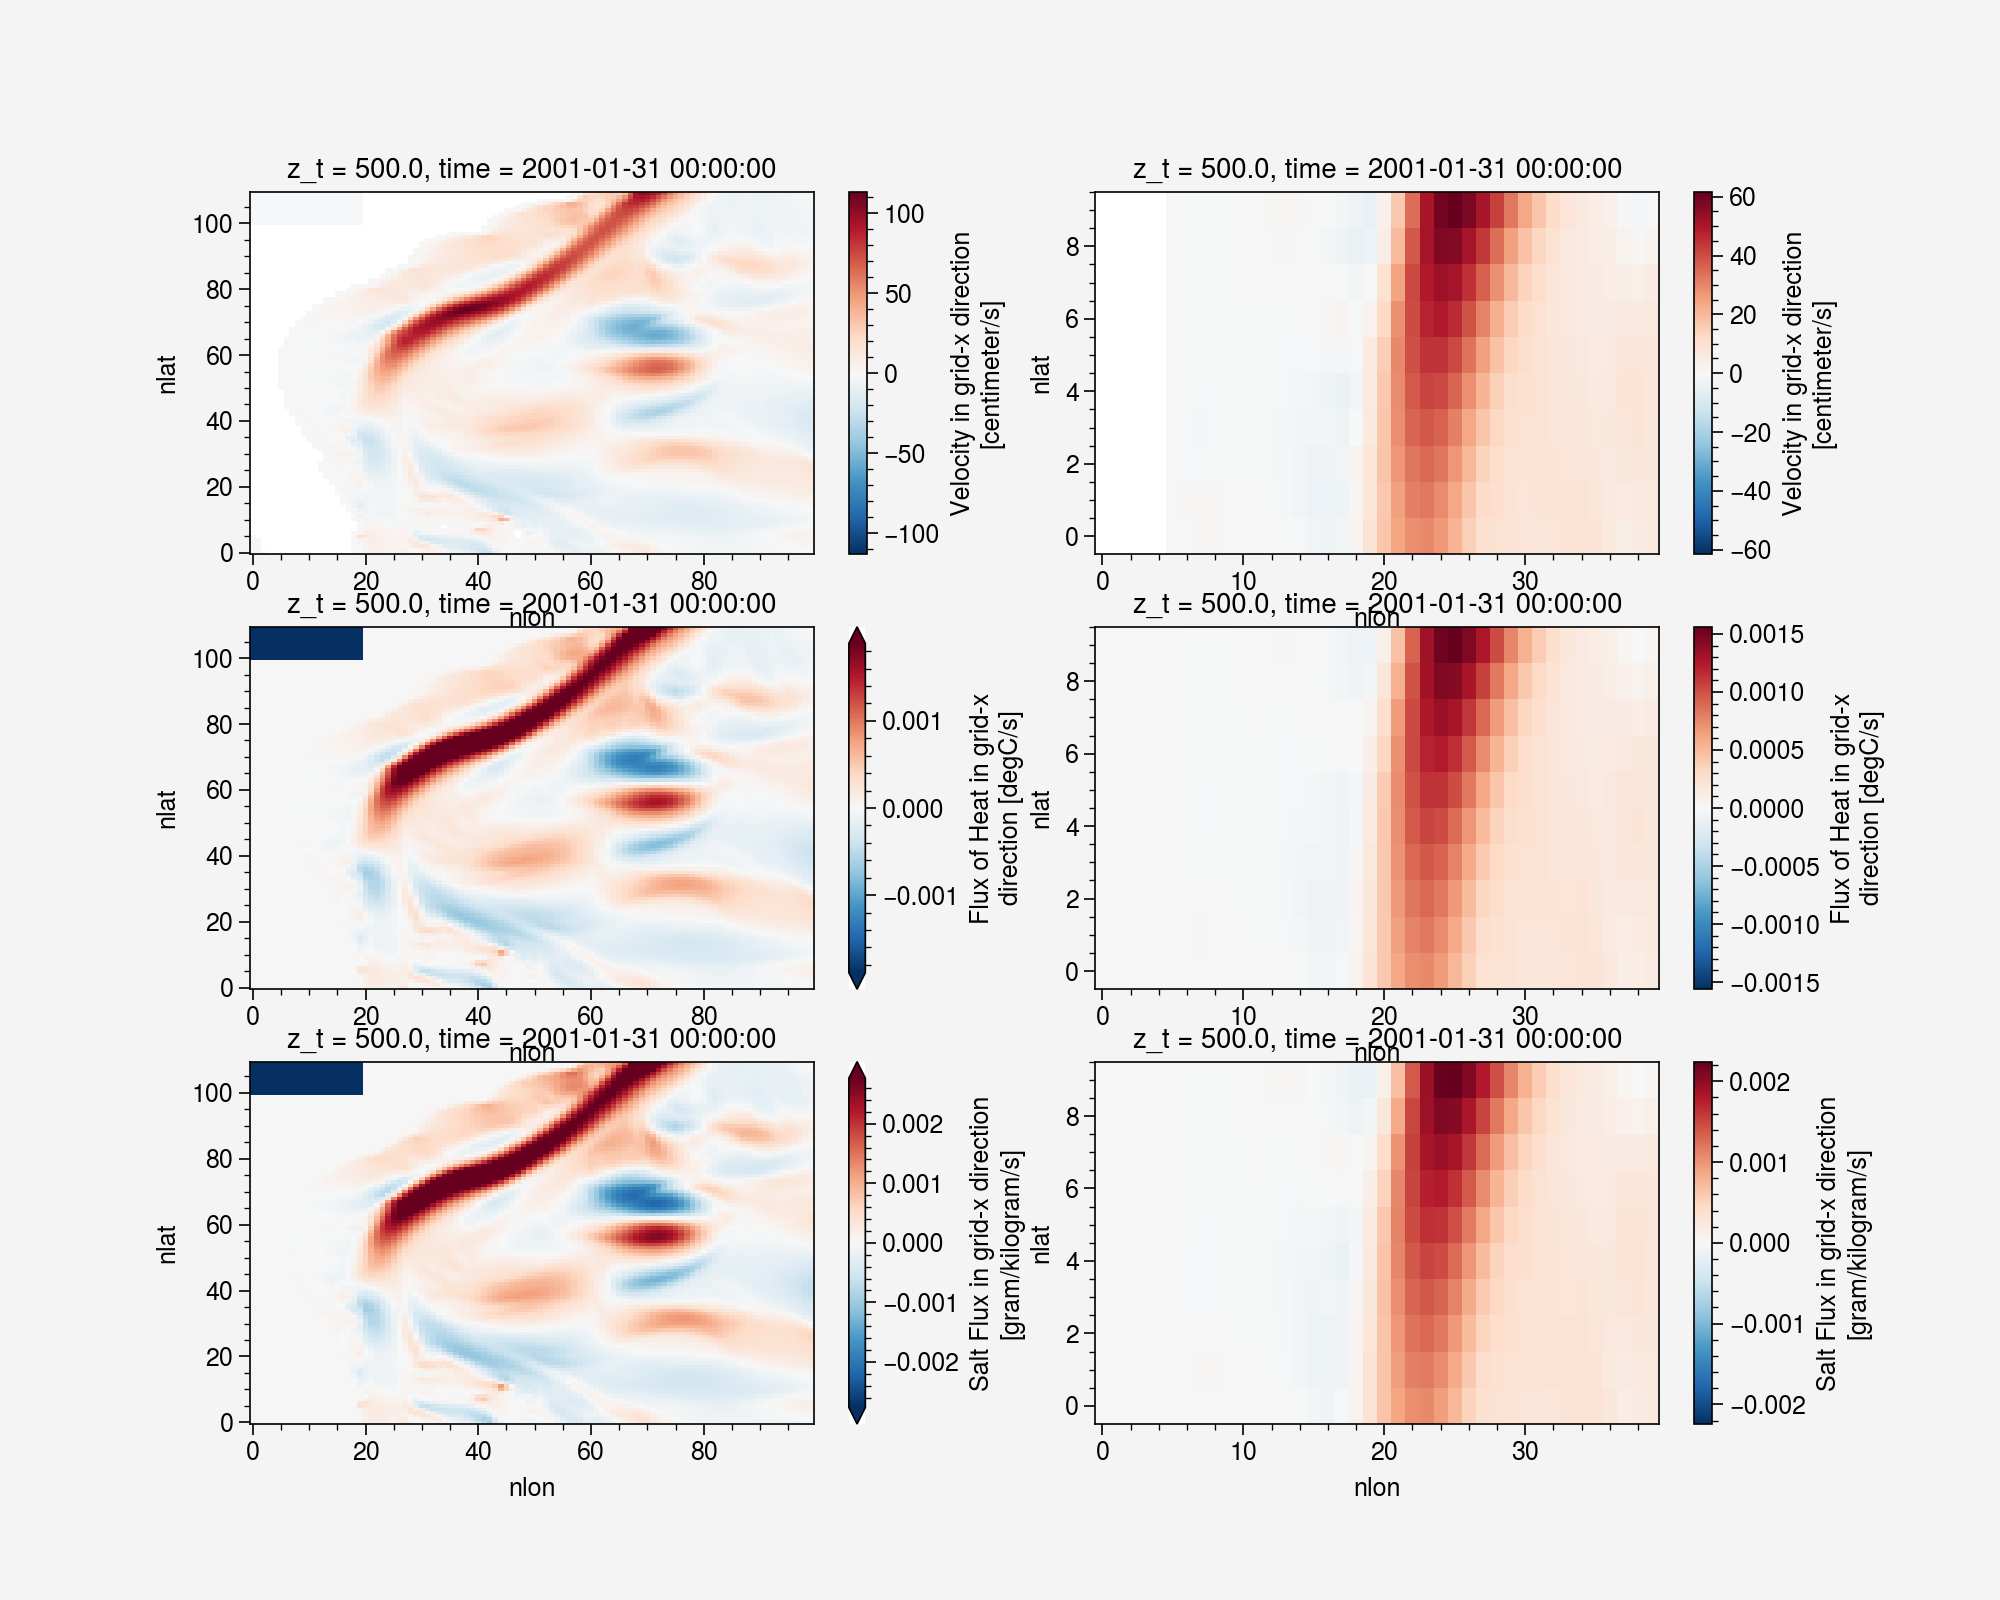

In [10]:
# ds_uvel_TH.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12)).TLONG
ilat1_t12, ilat2_t12 = 1500,1510
ilon1_t12, ilon2_t12 = 280, 320

fig, axs = plt.subplots(3,2, figsize=(10,8))
ds_uvel_TH.UVEL.isel(nlon=slice(ilon1_t12, ilon2_t12+60),nlat=slice(ilat1_t12-50, ilat2_t12+50),z_t=0,time=0).plot(ax=axs[0,0])
ds_uvel_TH.UVEL.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12),z_t=0,time=0).plot(ax=axs[0,1])
ds_uet_TH.UET.isel(nlon=slice(ilon1_t12, ilon2_t12+60),nlat=slice(ilat1_t12-50, ilat2_t12+50),z_t=0,time=0).plot(ax=axs[1,0],robust=True)
ds_uet_TH.UET.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12),z_t=0,time=0).plot(ax=axs[1,1])
ds_ues_TH.UES.isel(nlon=slice(ilon1_t12, ilon2_t12+60),nlat=slice(ilat1_t12-50, ilat2_t12+50),z_t=0,time=0).plot(ax=axs[2,0],robust=True)
ds_ues_TH.UES.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12),z_t=0,time=0).plot(ax=axs[2,1])


In [11]:
ds_uet_TH.UET

<xarray.DataArray 'UET' (time: 1200, z_t: 62, nlat: 2400, nlon: 3600)>
dask.array<concatenate, shape=(1200, 62, 2400, 3600), dtype=float32, chunksize=(12, 62, 400, 400), chunktype=numpy.ndarray>
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
  * time     (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Flux of Heat in grid-x direction
    units:         degC/s
    grid_loc:      3211
    cell_methods:  time: mean

In [15]:
# ilat1_t12, ilat2_t12 = 1500,1530-20
# ilon1_t12, ilon2_t12 = 280, 380
uet_r2_TH = ds_uet_TH.UET.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12))
ues_r2_TH = ds_ues_TH.UES.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12))
uvel_r2_TH = ds_uvel_TH.UVEL.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12))
temp_r2_TH = ds_temp_TH.TEMP.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12))
salt_r2_TH = ds_salt_TH.SALT.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12))
dxt_r2_TH = ds_temp_TH.DXT.isel(nlon=slice(ilon1_t12, ilon2_t12),nlat=slice(ilat1_t12, ilat2_t12))

alpha = 2.5e-4 # reference, POP manual Eq(8.6) ρ=ρ0−2.5×10−4Θ + 7.6×10−4S,
beta = 7.6e-4

ut_tot_r2_TH = -alpha*uet_r2_TH # [degC/s], positive mean flow moves towards to shore, increasing mass
ut_mfl_r2_TH = -alpha*uvel_r2_TH*temp_r2_TH/dxt_r2_TH # [degC/s], positive mean flow moves towards to shore, increasing mass
ut_eddy_r2_TH = ut_tot_r2_TH - ut_mfl_r2_TH
us_tot_r2_TH = beta*ues_r2_TH # [degC/s], positive mean flow moves towards to shore, increasing mass
us_mfl_r2_TH = beta*uvel_r2_TH*salt_r2_TH/dxt_r2_TH # [degC/s], positive mean flow moves towards to shore, increasing mass
us_eddy_r2_TH = us_tot_r2_TH - us_mfl_r2_TH

urho_tot_r2_TH = ut_tot_r2_TH + us_tot_r2_TH
urho_mfl_r2_TH = ut_mfl_r2_TH + us_mfl_r2_TH
urho_eddy_r2_TH = ut_eddy_r2_TH + us_eddy_r2_TH

urho_mfl_r2_t1av_TH = urho_mfl_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
urho_tot_r2_t1av_TH = urho_tot_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
urho_eddy_r2_t1av_TH = urho_eddy_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()

urho_mfl_r2_t2av_TH = urho_mfl_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()
urho_tot_r2_t2av_TH = urho_tot_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()
urho_eddy_r2_t2av_TH = urho_eddy_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()

# ut_mfl_r2_t1av_TH = ut_mfl_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
# ut_tot_r2_t1av_TH = ut_tot_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
# ut_eddy_r2_t1av_TH = ut_eddy_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()

# us_mfl_r2_t1av_TH = us_mfl_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
# us_tot_r2_t1av_TH = us_tot_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
# us_eddy_r2_t1av_TH = us_eddy_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()

# ut_mfl_r2_t2av_TH = ut_mfl_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()
# ut_tot_r2_t2av_TH = ut_tot_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()
# ut_eddy_r2_t2av_TH = ut_eddy_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()

# us_mfl_r2_t2av_TH = us_mfl_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()
# us_tot_r2_t2av_TH = us_tot_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()
# us_eddy_r2_t2av_TH = us_eddy_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()

temp_r2_t1av_TH = temp_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
temp_r2_t2av_TH = temp_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()
uvel_r2_t1av_TH = uvel_r2_TH.sel(time=slice('2001','2020')).mean(('nlat','time')).persist()
uvel_r2_t2av_TH = uvel_r2_TH.sel(time=slice('2081','2100')).mean(('nlat','time')).persist()

print(ut_mfl_r2_TH.dims)
# print(ut_tot_r2_TH.time[0].values, ut_tot_r2_TH.time[-1].values)

('time', 'z_t', 'nlat', 'nlon')


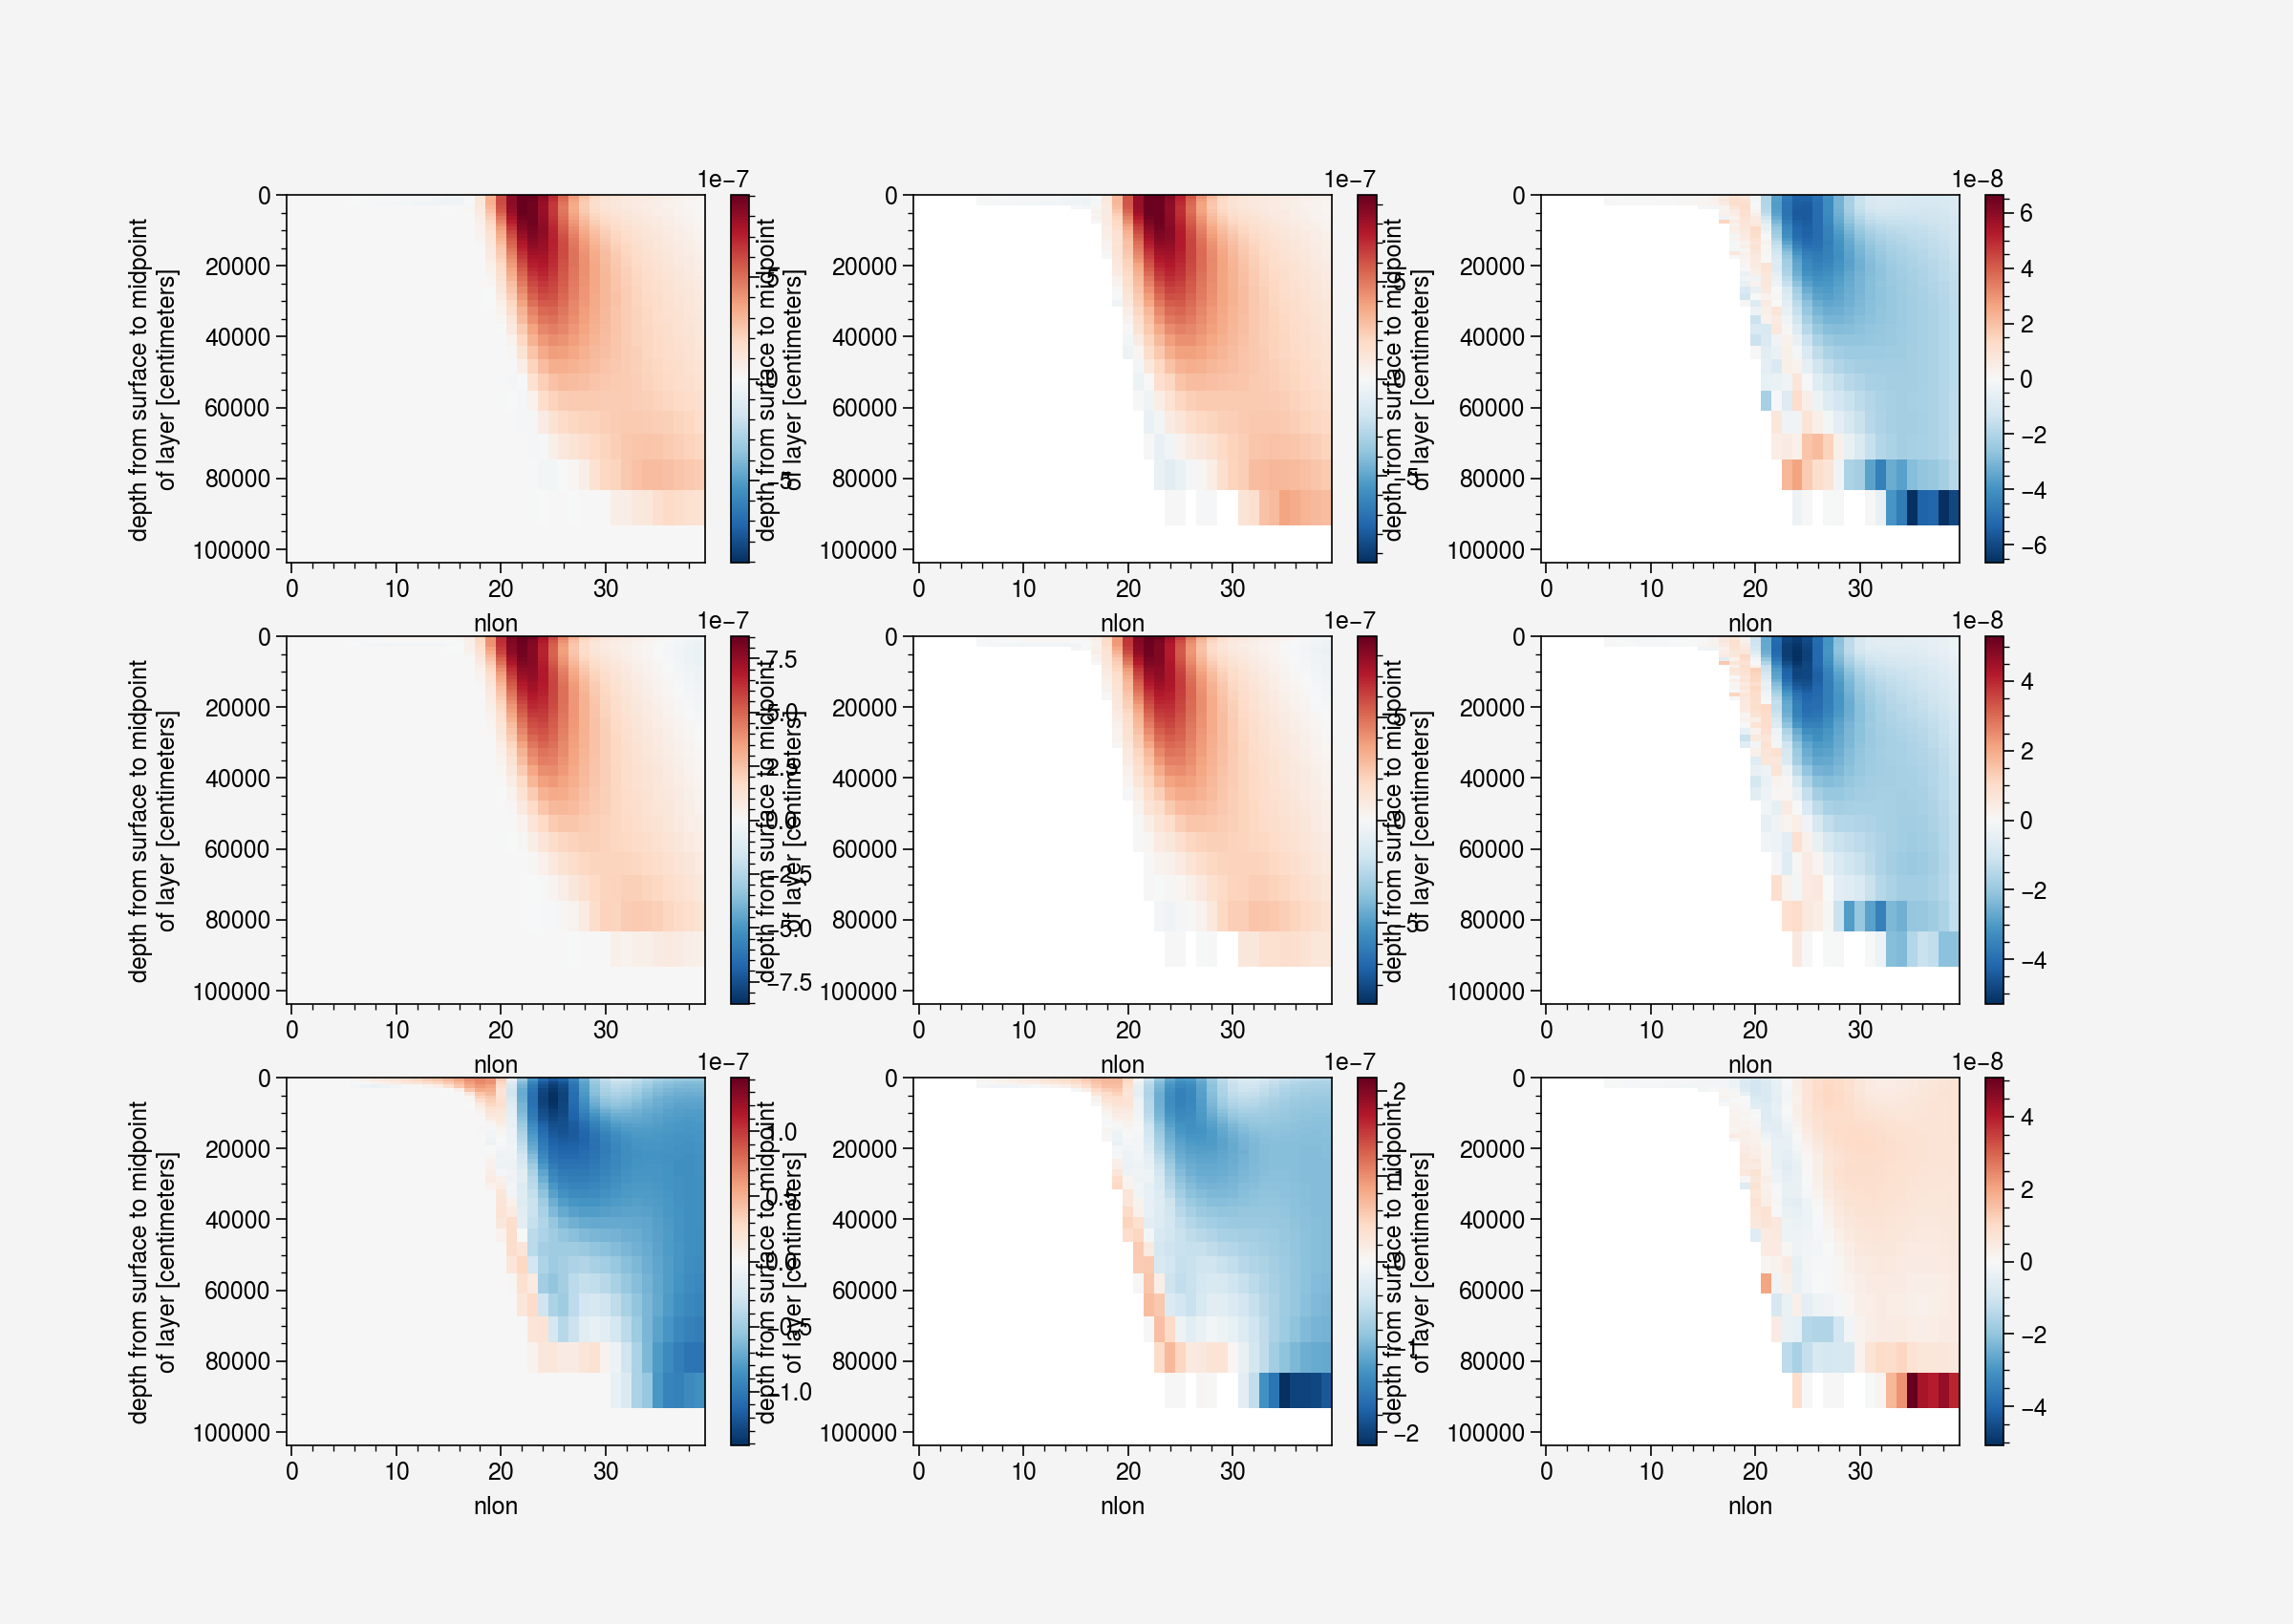

In [16]:
fig, axs = plt.subplots(3,3,figsize=(12,8.5))
# uvel_r2_TH.isel(time=0,z_t=0).plot(ax=axs[0,0],robust=True)
# uvel_r2_TH.isel(time=0).mean('nlat').plot(ax=axs[0,1], yincrease=False)
urho_tot_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,0], yincrease=False)
urho_mfl_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,1], yincrease=False)
urho_eddy_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,2], yincrease=False)

urho_tot_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,0], yincrease=False)
urho_mfl_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,1], yincrease=False)
urho_eddy_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,2], yincrease=False)

(urho_tot_r2_t2av_TH - urho_tot_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,0], yincrease=False)
(urho_mfl_r2_t2av_TH - urho_mfl_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,1], yincrease=False)
(urho_eddy_r2_t2av_TH - urho_eddy_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,2], yincrease=False)

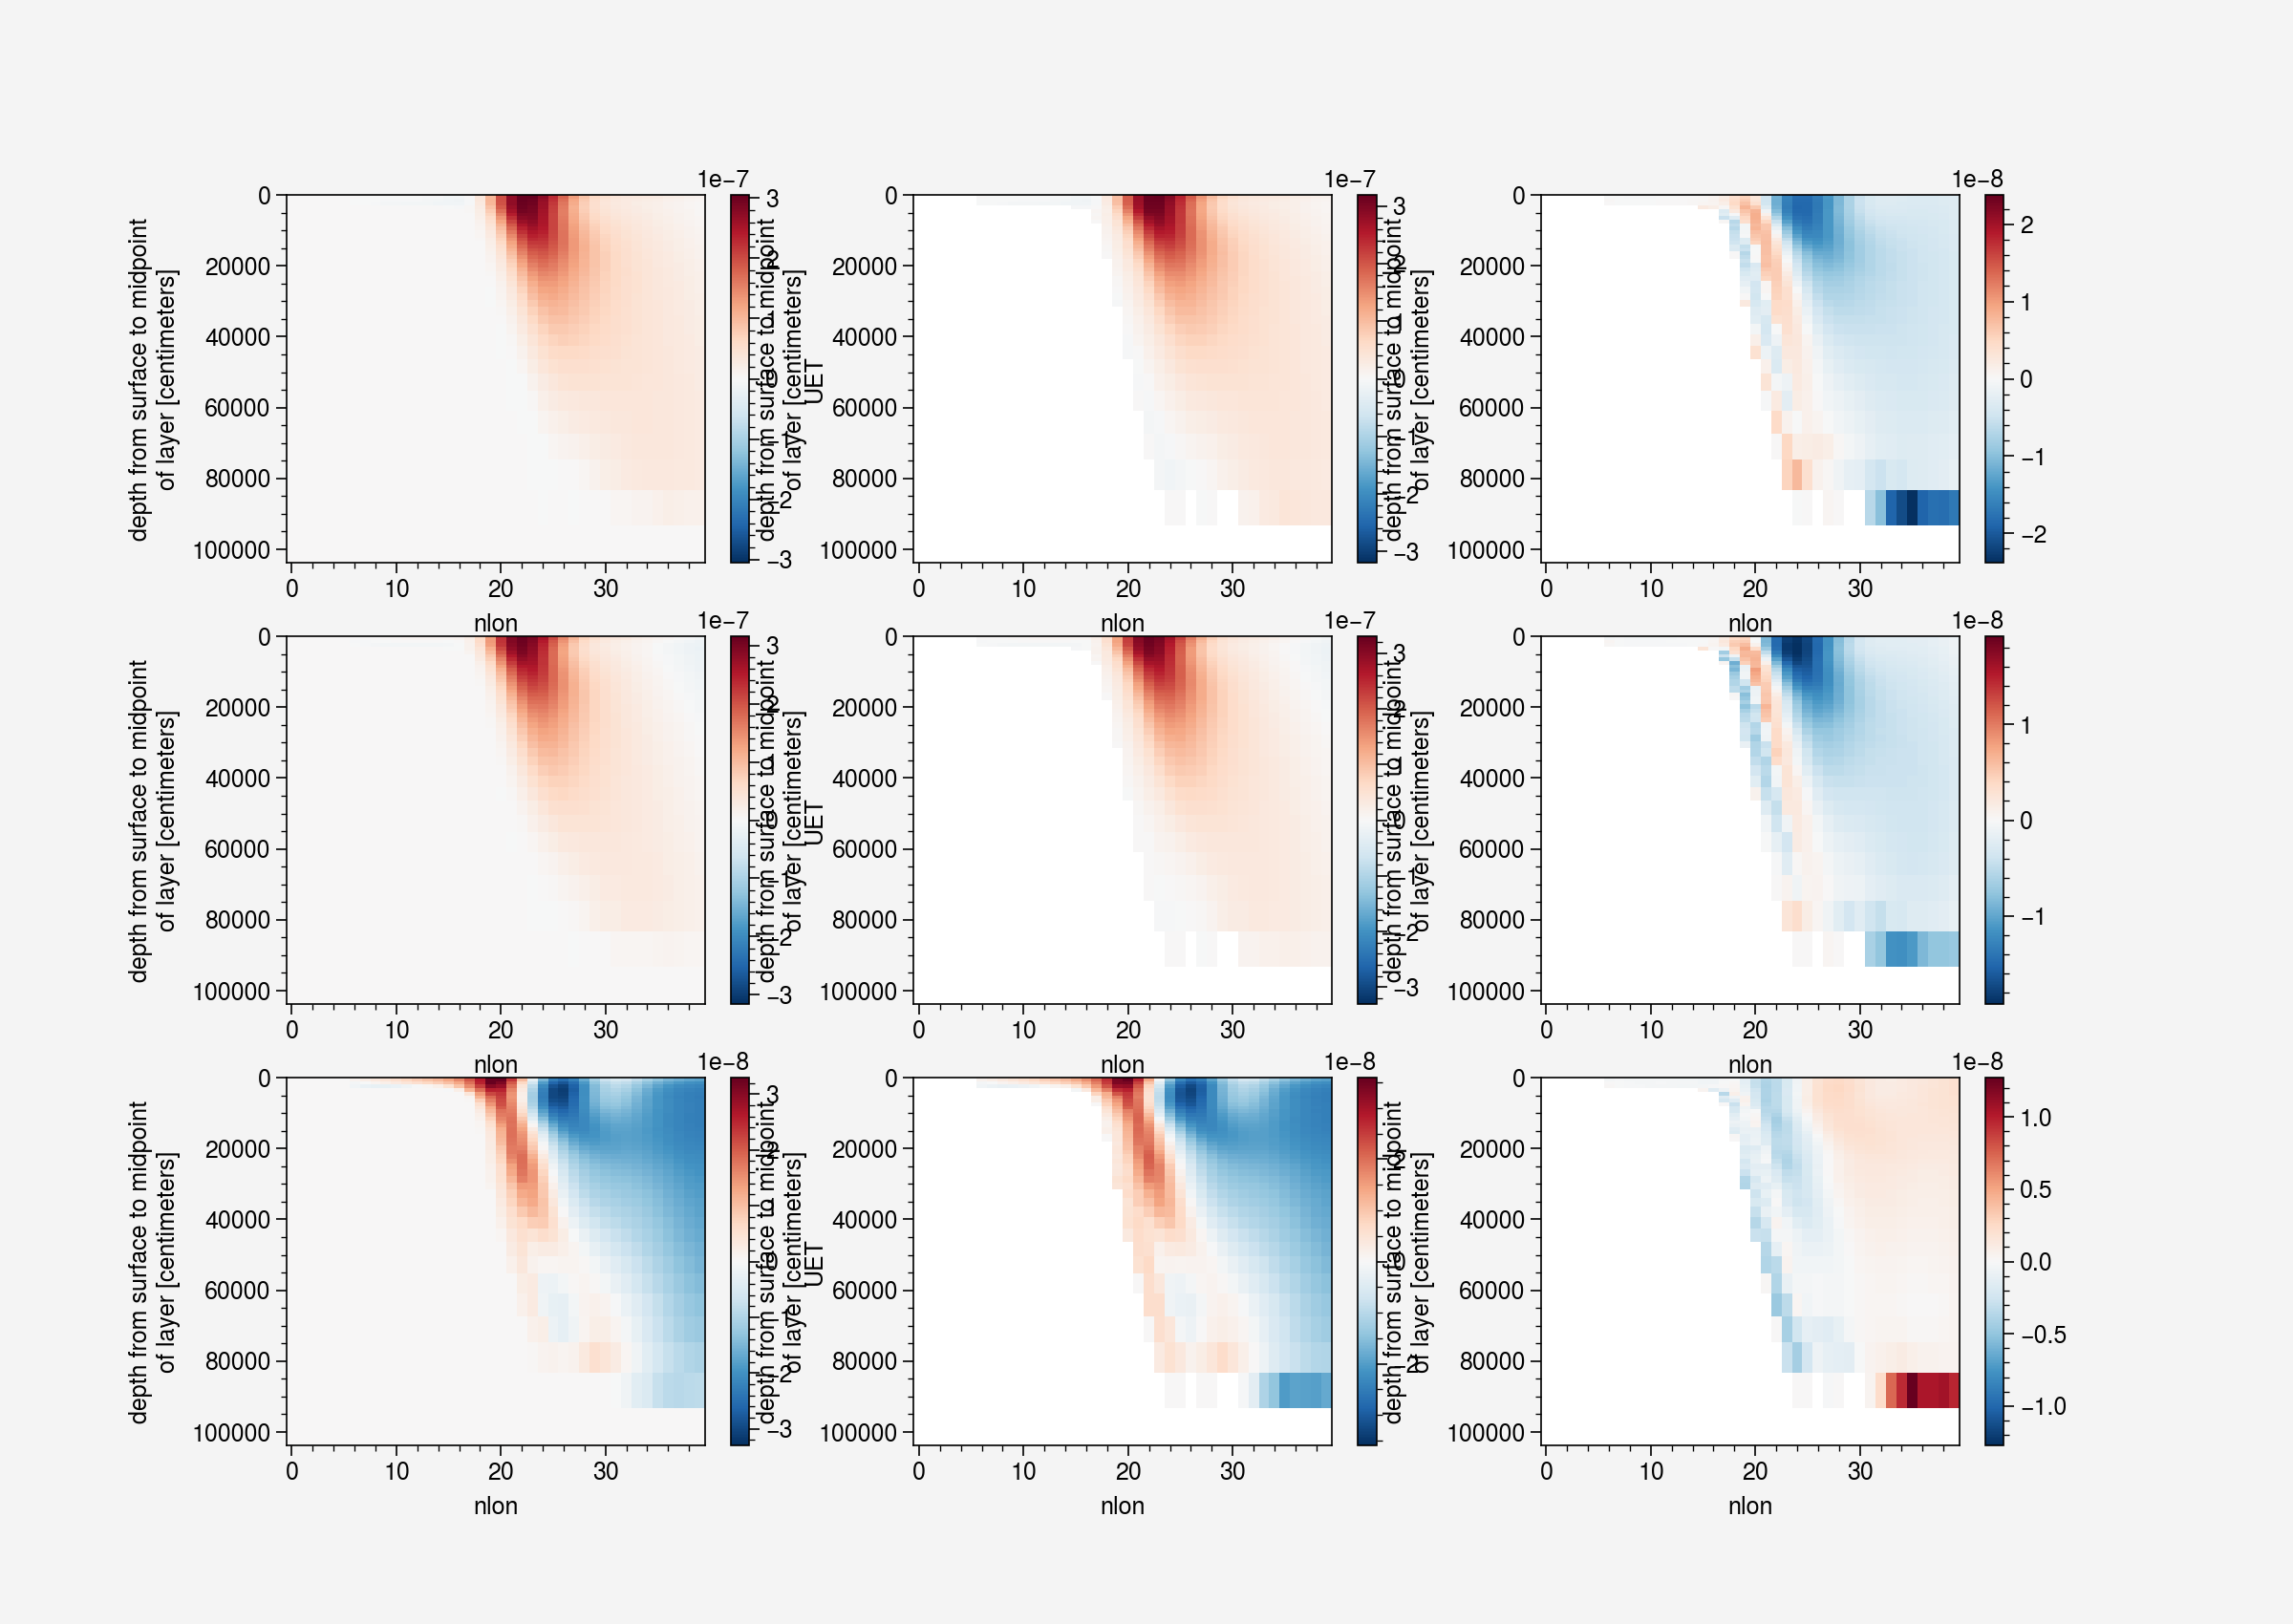

In [28]:
fig, axs = plt.subplots(3,3,figsize=(12,8.5))
# uvel_r2_TH.isel(time=0,z_t=0).plot(ax=axs[0,0],robust=True)
# uvel_r2_TH.isel(time=0).mean('nlat').plot(ax=axs[0,1], yincrease=False)
ut_tot_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,0], yincrease=False)
ut_mfl_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,1], yincrease=False)
ut_eddy_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,2], yincrease=False)

ut_tot_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,0], yincrease=False)
ut_mfl_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,1], yincrease=False)
ut_eddy_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,2], yincrease=False)

(ut_tot_r2_t2av_TH - ut_tot_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,0], yincrease=False)
(ut_mfl_r2_t2av_TH - ut_mfl_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,1], yincrease=False)
(ut_eddy_r2_t2av_TH - ut_eddy_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,2], yincrease=False)

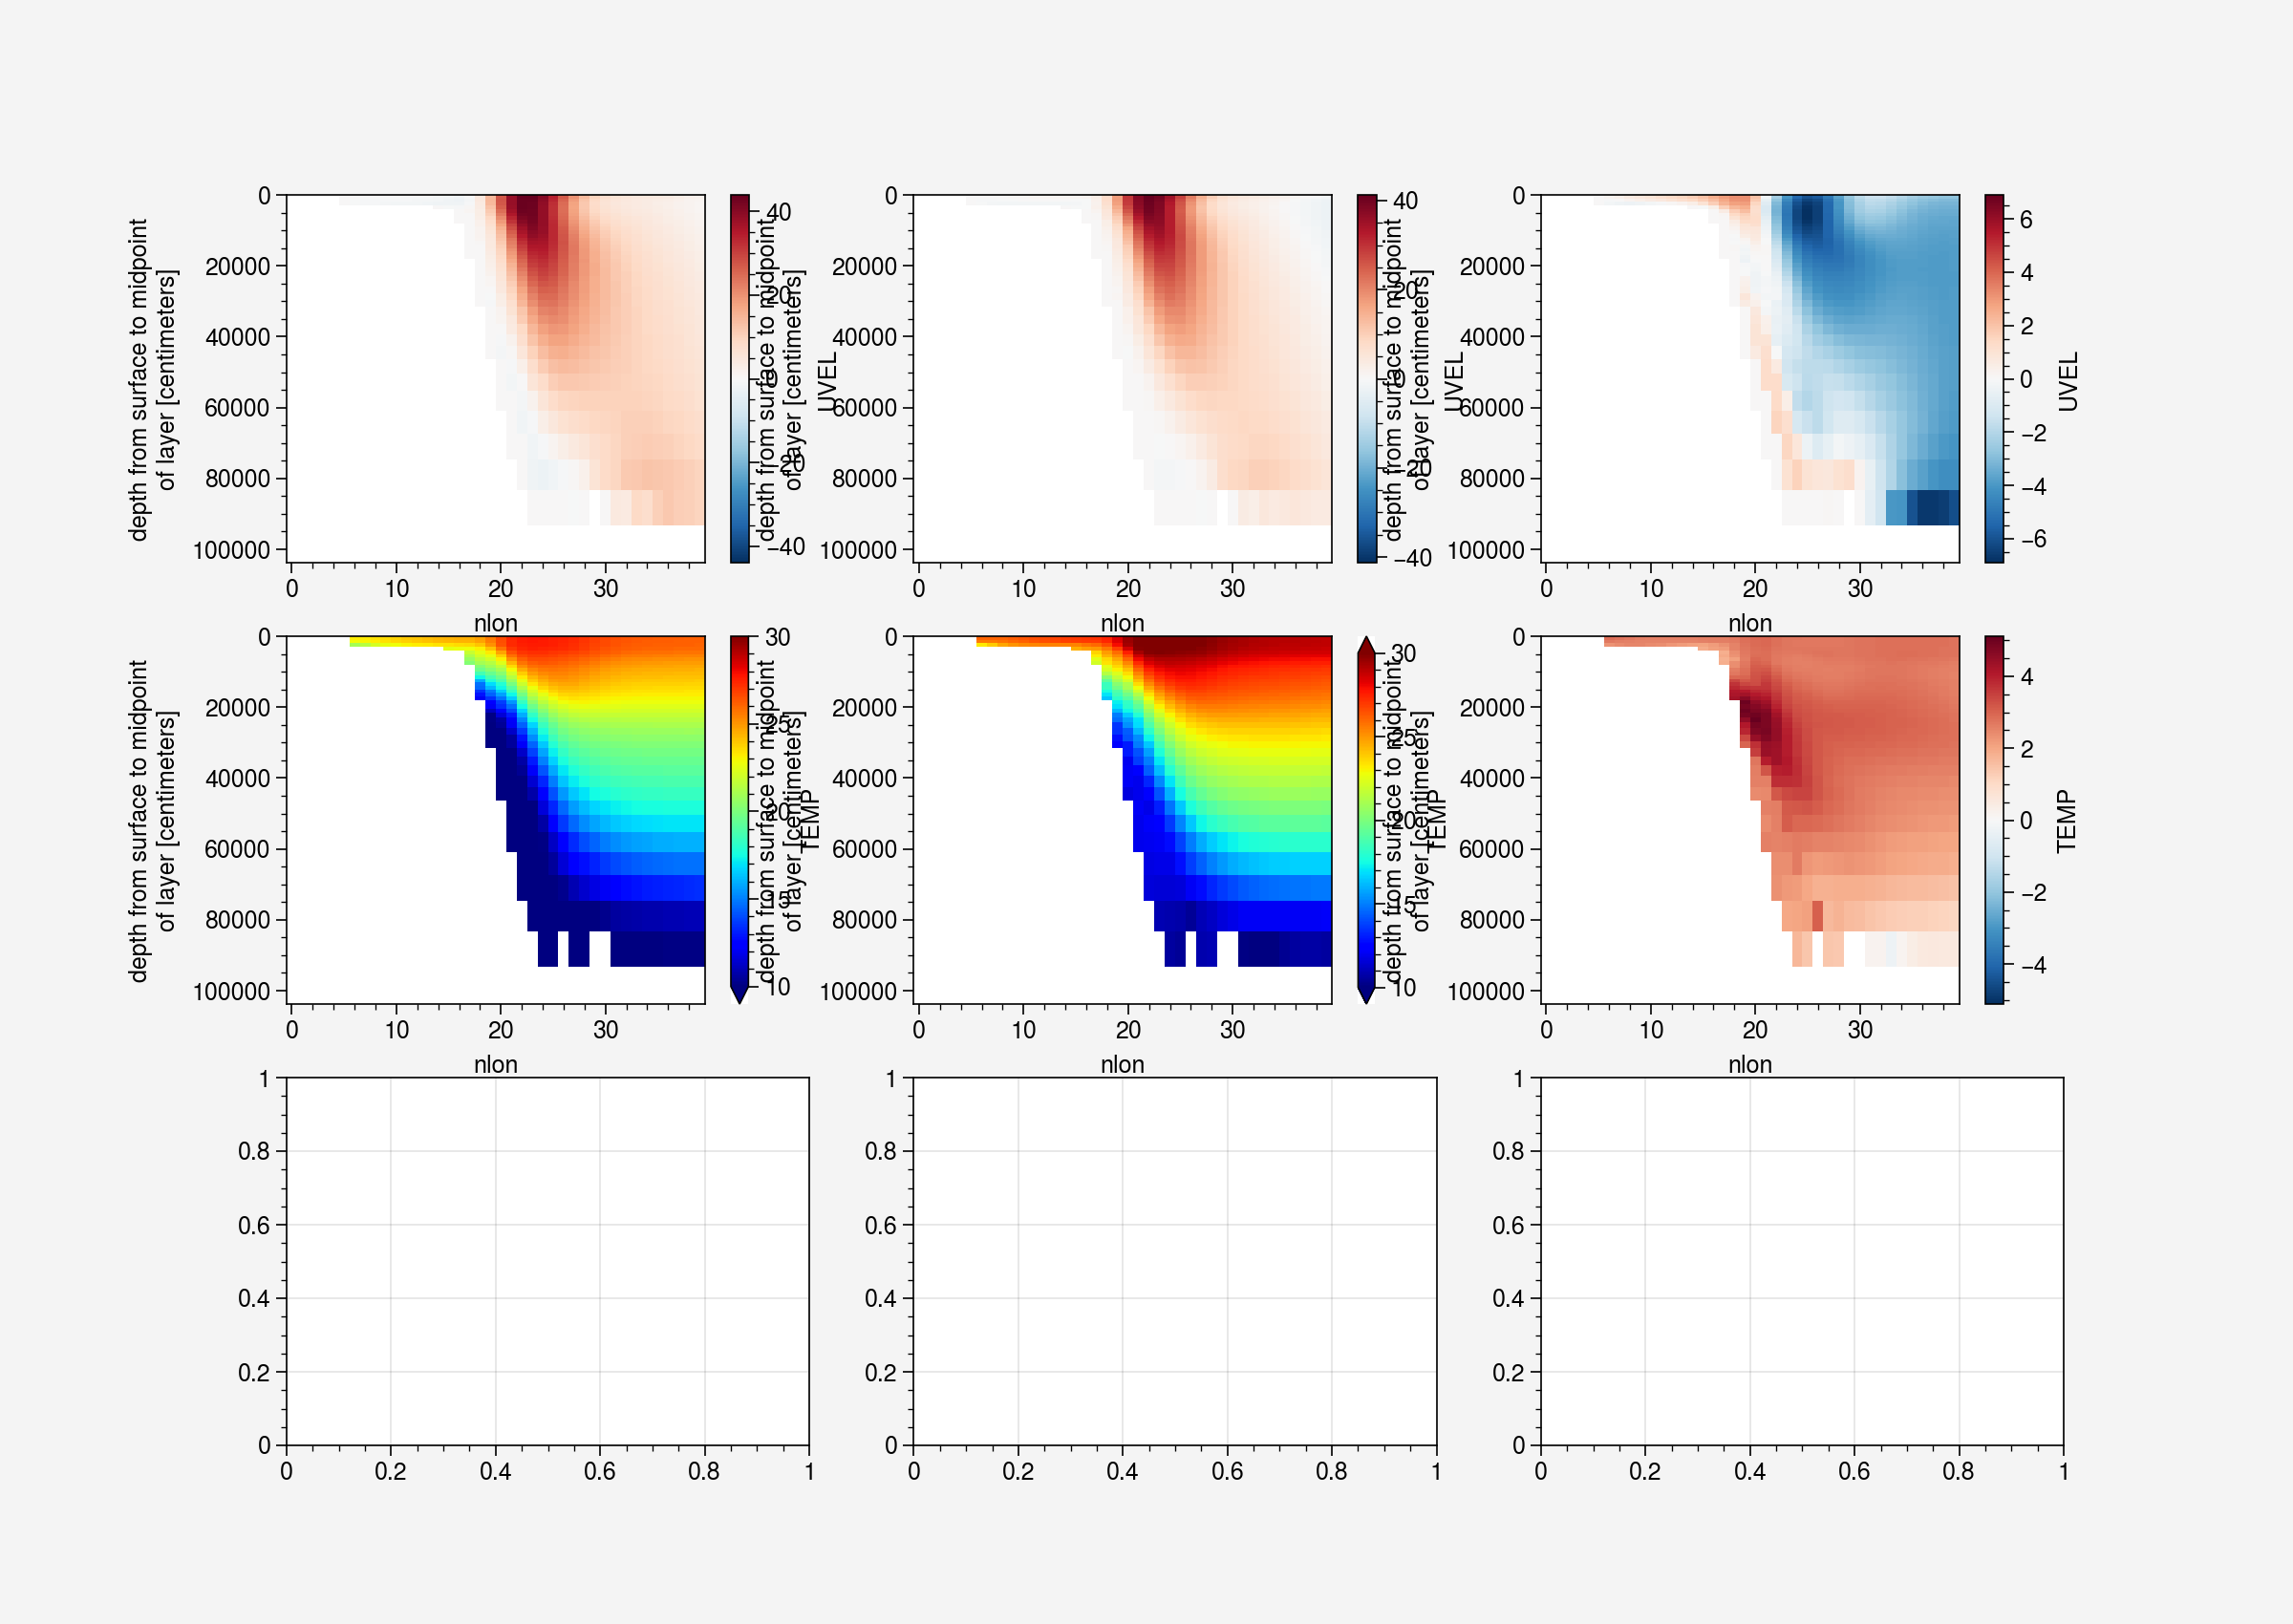

In [38]:
fig, axs = plt.subplots(3,3,figsize=(12,8.5))
# uvel_r2_TH.isel(time=0,z_t=0).plot(ax=axs[0,0],robust=True)
# uvel_r2_TH.isel(time=0).mean('nlat').plot(ax=axs[0,1], yincrease=False)
uvel_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,0], yincrease=False)
uvel_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,1], yincrease=False)
(uvel_r2_t2av_TH-uvel_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[0,2], yincrease=False)

temp_r2_t1av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,0], yincrease=False,cmap='jet',vmin=10, vmax=30)
temp_r2_t2av_TH.sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,1], yincrease=False,cmap='jet',vmin=10, vmax=30)
(temp_r2_t2av_TH-temp_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[1,2], yincrease=False)

# (ut_tot_r2_t2av_TH - ut_tot_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,0], yincrease=False)
# (ut_mfl_r2_t2av_TH - ut_mfl_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,1], yincrease=False)
# (ut_eddy_r2_t2av_TH - ut_eddy_r2_t1av_TH).sel(z_t=slice(0,1000*1e2)).plot(ax=axs[2,2], yincrease=False)

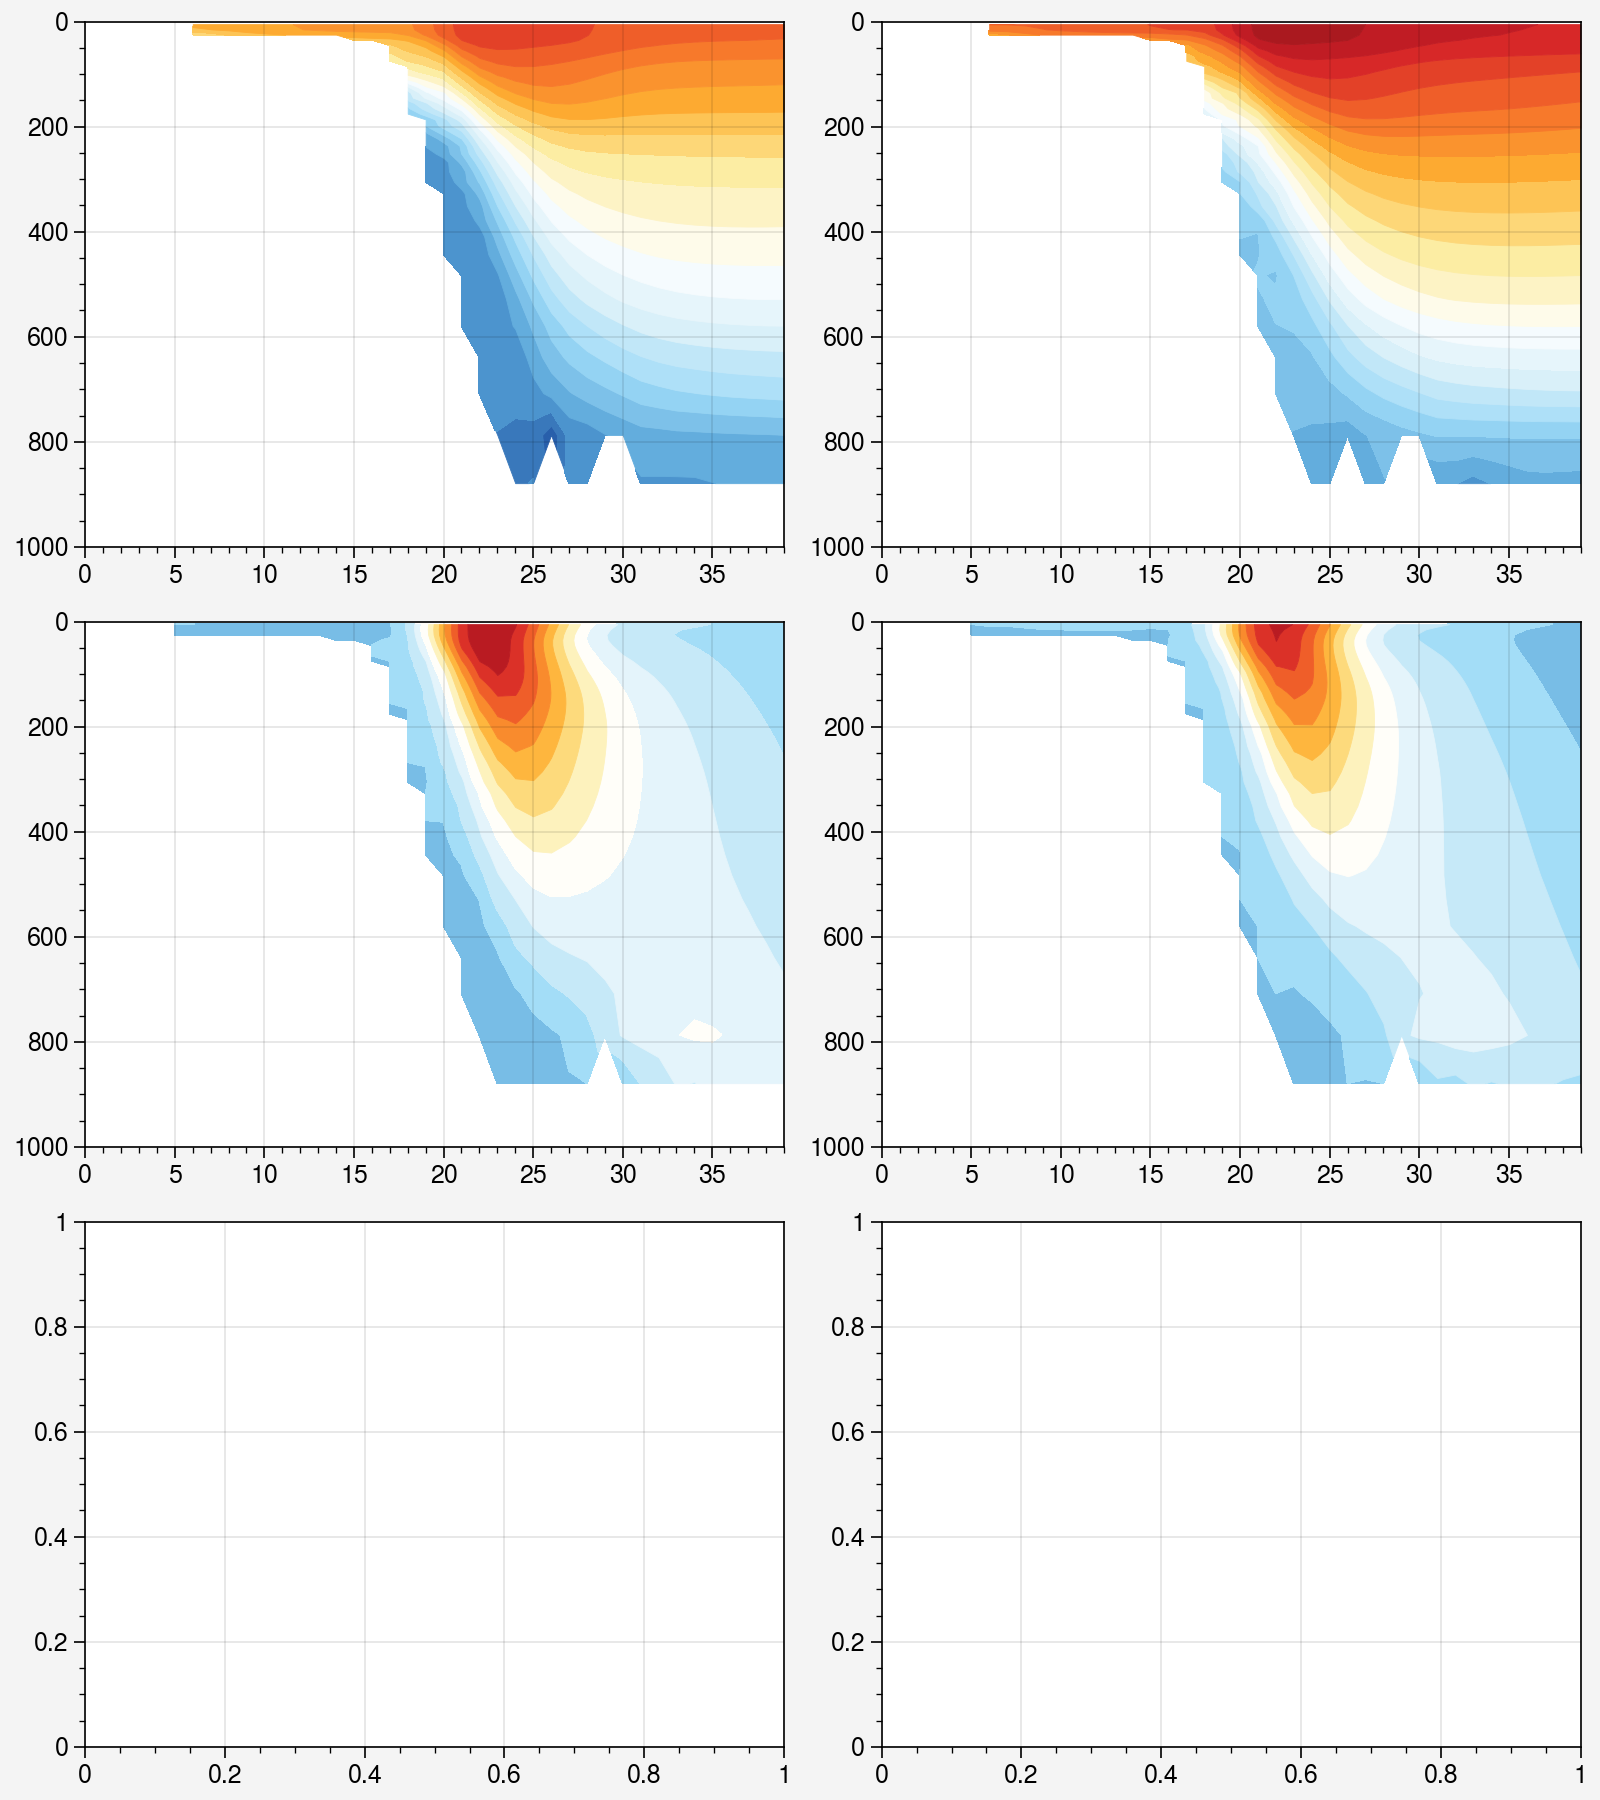

In [105]:
fig1, axs = plot.subplots(nrows=3,ncols=2,width='8in',height='9in',share=False)

# temp_r2_t1av_TH.isel(nlon=slice(0,50),z_t=slice(0,50)).plot(ax=axs[0], yincrease=False,vmin=20, vmax=25, cmap='bwr')
# temp_r2_t2av_TH.isel(nlon=slice(0,50),z_t=slice(0,50)).plot(ax=axs[1], yincrease=False,vmin=20, vmax=25, cmap='bwr')
axs[0, 0].contourf(temp_r2_t1av_TH.nlon.values, temp_r2_t1av_TH.z_t.values/100, temp_r2_t1av_TH.values, levels=np.arange(4,32.01,1), cmap='ColdHot')
# axs[0, 0].set_xlim([278,284])
axs[0, 0].set_ylim([0,1000])
axs[0, 0].invert_yaxis()

axs[0, 1].contourf(temp_r2_t1av_TH.nlon.values, temp_r2_t2av_TH.z_t.values/100, temp_r2_t2av_TH.values, levels=np.arange(4,32.01,1), cmap='ColdHot')
# axs[0, 1].set_xlim([278,284])
axs[0, 1].set_ylim([0,1000])
axs[0, 1].invert_yaxis()

axs[1, 0].contourf(uvel_r2_t1av_TH.nlon.values, uvel_r2_t1av_TH.z_t.values/100, uvel_r2_t1av_TH.values, levels=np.arange(-20,50,4), cmap='ColdHot')
# axs[0, 0].set_xlim([278,284])
axs[1, 0].set_ylim([0,1000])
axs[1, 0].invert_yaxis()

axs[1, 1].contourf(uvel_r2_t2av_TH.nlon.values, uvel_r2_t2av_TH.z_t.values/100, uvel_r2_t2av_TH.values, levels=np.arange(-20,50,4), cmap='ColdHot')
# axs[0, 1].set_xlim([278,284])
axs[1, 1].set_ylim([0,1000])
axs[1, 1].invert_yaxis()



# axs[1, 0].plot(tlon_r2,temp_r2_t1av_TH.mean('z_t')+2.8, color='b')
# axs[1, 0].plot(tlon_r2,temp_r2_t2av_TH.mean('z_t'), color='r')
# axs[1,0].set_xlim([278,284])

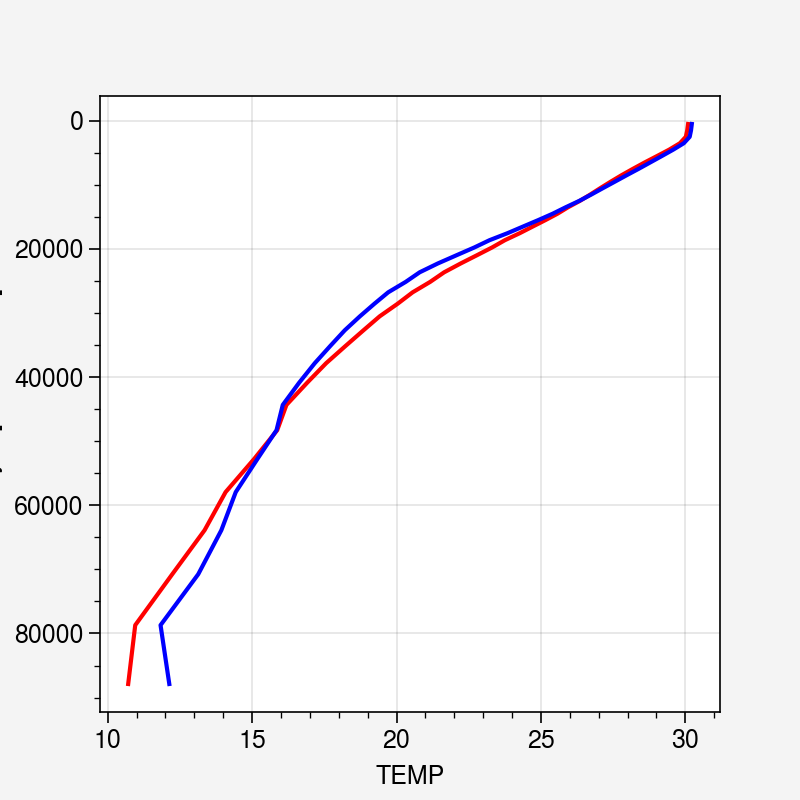

In [100]:
# temp_r2_t1av_TH.mean('z_t').plot(color='b')
# temp_r2_t2av_TH.mean('z_t').plot(color='r')
temp_r2_t2av_TH.sel(nlon=slice(20,30)).mean('nlon').plot(color='r',y='z_t',yincrease=False)
(temp_r2_t1av_TH.sel(nlon=slice(20,30)).mean('nlon')+2.9).plot(color='b',y='z_t',yincrease=False)

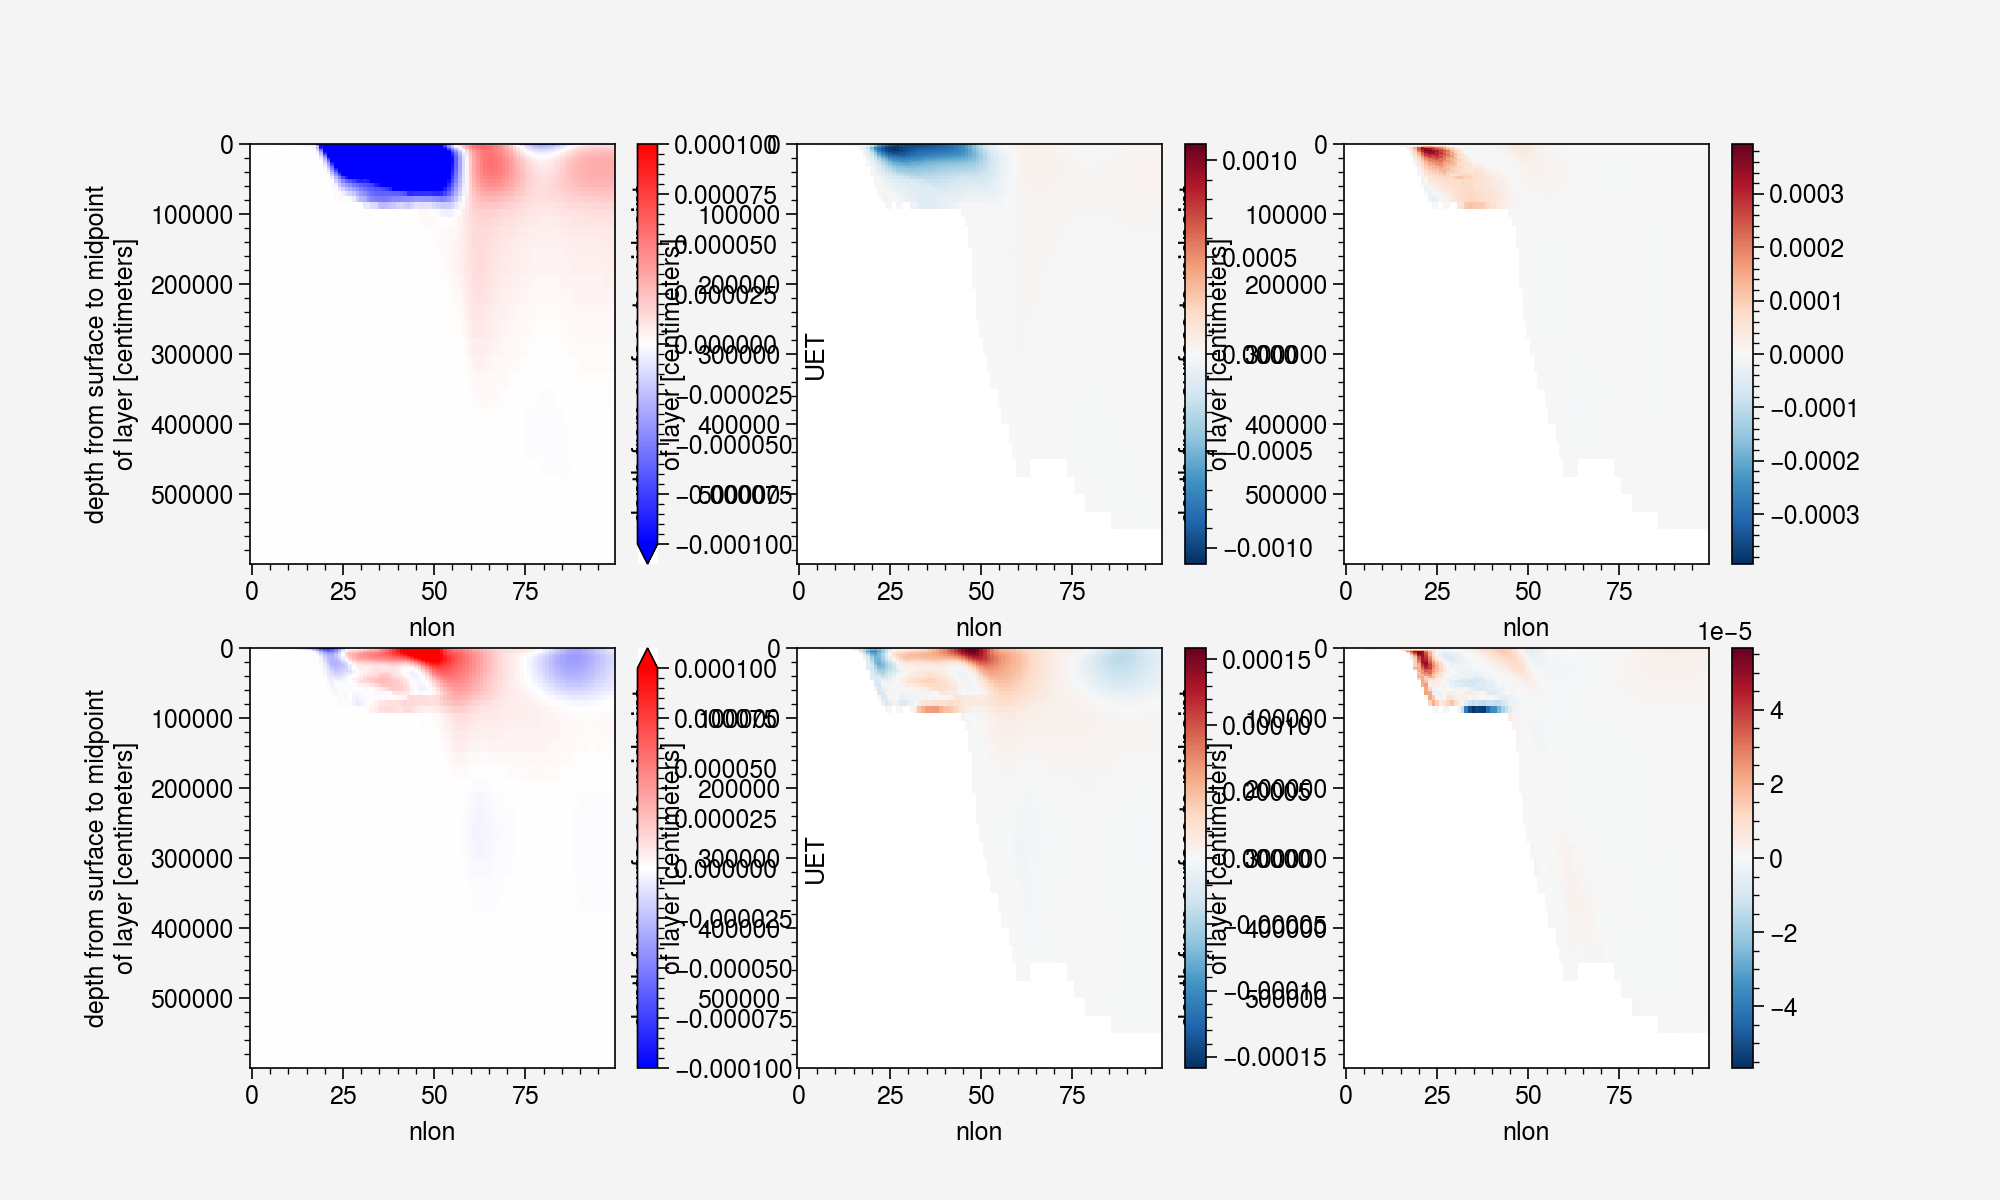

In [10]:
fig, axs = plt.subplots(2,3,figsize=(10,6))
ut_tot_r2_t1av_TH.plot(ax=axs[0,0], yincrease=False, vmin=-1e-4,vmax=1e-4,cmap='bwr')
ut_mfl_r2_t1av_TH.plot(ax=axs[0,1], yincrease=False)
ut_eddy_r2_t1av_TH.plot(ax=axs[0,2], yincrease=False)

(ut_tot_r2_t2av_TH - ut_tot_r2_t1av_TH).plot(ax=axs[1,0], yincrease=False, vmin=-1e-4,vmax=1e-4,cmap='bwr')
(ut_mfl_r2_t2av_TH - ut_mfl_r2_t1av_TH).plot(ax=axs[1,1], yincrease=False)
(ut_eddy_r2_t2av_TH-ut_eddy_r2_t1av_TH).plot(ax=axs[1,2], yincrease=False)

In [8]:
ds_TH = xr.Dataset()
ds_TH

ds_TH["UVEL"] = ds_uvel_TH.UVEL
ds_TH["VVEL"] = ds_vvel_TH.VVEL
ds_TH["TEMP"] = ds_temp_TH.TEMP
ds_TH["SALT"] = ds_salt_TH.SALT
ds_TH["DXU"] = ds_uvel_TH.DXU.compute() # cm
ds_TH["DXT"] = ds_uvel_TH.DXT.compute() # cm
ds_TH["DYU"] = ds_uvel_TH.DYU.compute() # cm
ds_TH["DYT"] = ds_uvel_TH.DYT.compute() # cm
ds_TH["DZU"] = ds_3dDZU_t12.DZU*100 # cm
ds_TH["DZT"] = ds_3dDZT_t12.DZT*100 # cm
ds_TH["UAREA"] = ds_uvel_TH.UAREA.compute() # cm2
ds_TH["TAREA"] = ds_uvel_TH.TAREA.compute() # cm2
ds_TH["KMU"] = ds_uvel_TH.KMU.compute() #
ds_TH["KMT"] = ds_uvel_TH.KMT.compute() #
ds_TH.DZT.attrs["long_name"] = "Thickness of T cells"
ds_TH.DZT.attrs["units"] = "centimeter"
ds_TH.DZT.attrs["grid_loc"] = "3111"
ds_TH.DZU.attrs["long_name"] = "Thickness of U cells"
ds_TH.DZU.attrs["units"] = "centimeter"
ds_TH.DZU.attrs["grid_loc"] = "3221"
ds_TH

# ds_hdift_r_TL = ds_hdift_TL.isel(nlon=slice(nlon1_r_g16, nlon2_r_g16), nlat=slice(nlat1_r_g16, nlat2_r_g16))
ds_r_TH = ds_TH.isel(nlon=slice(nlon1_r_t12, nlon2_r_t12), nlat=slice(nlat1_r_t12, nlat2_r_t12))

# ds_hdift_tre_r_TL = ds_hdift_TL.resample(time='A').mean('time')
# ds_uvel_tre_r_TL = ds_uvel_TL.resample(time='A').mean('time')
ds_r_TH

print('loop start')
# make sure we have the cell volumne for calculations
VOL = (ds_r_TH.DZT * ds_r_TH.DXT * ds_r_TH.DYT).compute()
KMT = ds_r_TH.KMT.compute()

for j in tqdm(range(len(KMT.nlat))):
    for i in range(len(KMT.nlon)):
        k = KMT.values[j, i].astype(int)
        VOL.values[k:, j, i] = 0.0

ds_r_TH["VOL"] = VOL

ds_r_TH.VOL.attrs["long_name"] = "volume of T cells"
ds_r_TH.VOL.attrs["units"] = "centimeter^3"

ds_r_TH.VOL.attrs["grid_loc"] = "3111"


metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],}

grid_r_TH, xds_r_TH = pop_tools.to_xgcm_grid_dataset(ds_r_TH, 
                                                             periodic=False,
                                                             metrics=metrics,
                                                             boundary={"X": "extend", "Y": "extend", "Z": "extend"},)


for coord in ["nlat", "nlon"]:
    if coord in xds_r_TH.coords:
        xds_r_TH = xds_r_TH.drop_vars(coord)
        
xds_r_TH

loop start


100%|██████████| 500/500 [00:00<00:00, 849.06it/s]


<xarray.Dataset>
Dimensions:  (nlat_t: 500, nlat_u: 500, nlon_t: 400, nlon_u: 400, time: 1200, z_t: 62)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
    ULONG    (nlat_u, nlon_u) float64 dask.array<chunksize=(200, 150), meta=np.ndarray>
    ULAT     (nlat_u, nlon_u) float64 dask.array<chunksize=(200, 150), meta=np.ndarray>
    TLONG    (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 150), meta=np.ndarray>
    TLAT     (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 150), meta=np.ndarray>
  * time     (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
  * nlon_u   (nlon_u) int64 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400
  * nlat_u   (nlat_u) int64 1 2 3 4 5 6 7 8 ... 493 494 495 496 497 498 499 500
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 396.5 397.5 398.5 399.5
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 496.5 497.5 498.5 499.5
Data variables: (12/15)
    UVEL     (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(12, 62, 200, 150), meta=np.ndarray>
    VVEL     (time, z_t, nlat_u, nlon_u) float32 dask.array<chunksize=(12, 62, 200, 150), meta=np.ndarray>
    TEMP     (time, z_t, nlat_t, nlon_t) float32 dask.array<chunksize=(12, 62, 200, 150), meta=np.ndarray>
    SALT     (time, z_t, nlat_t, nlon_t) float32 dask.array<chunksize=(12, 62, 200, 150), meta=np.ndarray>
    DXU      (nlat_u, nlon_u) float64 1.035e+06 1.035e+06 ... 6.221e+05
    DXT      (nlat_t, nlon_t) float64 1.036e+06 1.036e+06 ... 6.225e+05
    ...       ...
    DZT      (z_t, nlat_t, nlon_t) float64 1e+03 1e+03 1e+03 ... nan nan nan
    UAREA    (nlat_u, nlon_u) float64 1.072e+12 1.072e+12 ... 4.265e+11
    TAREA    (nlat_t, nlon_t) float64 1.073e+12 1.073e+12 ... 4.269e+11
    KMU      (nlat_u, nlon_u) float64 52.0 53.0 54.0 54.0 ... 47.0 44.0 39.0
    KMT      (nlat_t, nlon_t) float64 54.0 54.0 55.0 55.0 ... 49.0 49.0 47.0
    VOL      (z_t, nlat_t, nlon_t) float64 1.073e+15 1.073e+15 ... 0.0 0.0

In [9]:
# uvel_yintp_r_TH = grid_uvel_r_TH.interp(xds_uvel_r_TH.UVEL, 'Y')
# uvel_yintp_r_TH
uvel_yintp_r_TH = grid_r_TH.interp(xds_r_TH.UVEL, 'Y')
uvel_yintp_r_TH

,Array,Chunk
Bytes,55.43 GiB,212.15 MiB
Shape,"(1200, 62, 500, 400)","(12, 62, 299, 250)"
Count,17100 Tasks,800 Chunks
Type,float32,numpy.ndarray


In [10]:
# vvel_xintp_r_TH = grid_uvel_r_TH.interp(xds_uvel_r_TH.VVEL, 'X')
# vvel_xintp_r_TH
vvel_xintp_r_TH = grid_r_TH.interp(xds_r_TH.VVEL, 'X')
vvel_xintp_r_TH

,Array,Chunk
Bytes,55.43 GiB,212.01 MiB
Shape,"(1200, 62, 500, 400)","(12, 62, 300, 249)"
Count,17100 Tasks,800 Chunks
Type,float32,numpy.ndarray


In [11]:
# xds_uvel_r_TH.TEMP
# temp_xintp_r_TH = grid_uvel_r_TH.interp(xds_uvel_r_TH.TEMP, 'X')
# salt_xintp_r_TH = grid_uvel_r_TH.interp(xds_uvel_r_TH.SALT, 'X')
# temp_xintp_r_TH
xds_r_TH.TEMP
temp_xintp_r_TH = grid_r_TH.interp(xds_r_TH.TEMP, 'X')
salt_xintp_r_TH = grid_r_TH.interp(xds_r_TH.SALT, 'X')
temp_xintp_r_TH

,Array,Chunk
Bytes,55.43 GiB,212.01 MiB
Shape,"(1200, 62, 500, 400)","(12, 62, 300, 249)"
Count,17100 Tasks,800 Chunks
Type,float32,numpy.ndarray


In [12]:
# temp_yintp_r_TH = grid_uvel_r_TH.interp(xds_uvel_r_TH.TEMP, 'Y')
# salt_yintp_r_TH = grid_uvel_r_TH.interp(xds_uvel_r_TH.SALT, 'Y')
# temp_yintp_r_TH
temp_yintp_r_TH = grid_r_TH.interp(xds_r_TH.TEMP, 'Y')
salt_yintp_r_TH = grid_r_TH.interp(xds_r_TH.SALT, 'Y')
temp_yintp_r_TH

,Array,Chunk
Bytes,55.43 GiB,212.15 MiB
Shape,"(1200, 62, 500, 400)","(12, 62, 299, 250)"
Count,17100 Tasks,800 Chunks
Type,float32,numpy.ndarray


In [13]:
uet_mfl_r_TH = uvel_yintp_r_TH*temp_xintp_r_TH
ues_mfl_r_TH = uvel_yintp_r_TH*salt_xintp_r_TH
uet_mfl_r_TH

,Array,Chunk
Bytes,55.43 GiB,211.30 MiB
Shape,"(1200, 62, 500, 400)","(12, 62, 299, 249)"
Count,42200 Tasks,1600 Chunks
Type,float32,numpy.ndarray


In [14]:
vnt_mfl_r_TH = vvel_xintp_r_TH*temp_yintp_r_TH
vns_mfl_r_TH = vvel_xintp_r_TH*salt_yintp_r_TH
vnt_mfl_r_TH

,Array,Chunk
Bytes,55.43 GiB,211.30 MiB
Shape,"(1200, 62, 500, 400)","(12, 62, 299, 249)"
Count,42200 Tasks,1600 Chunks
Type,float32,numpy.ndarray


In [15]:
# vnt_mfl_r_TH.isel(time=0,z_t=0).plot(robust=True) # [cm/s*degC]
uet_mfl_r_TH.dims

('time', 'z_t', 'nlat_t', 'nlon_u')

In [16]:
# duet_mfl_r_TH = -(grid_uvel_r_TH.diff(uet_mfl_r_TH * xds_uvel_r_TH.VOL.values, axis="X") / xds_uvel_r_TH.VOL)/xds_uvel_r_TH.DXT
# # [degC/s]
# dvnt_mfl_r_TH = -(grid_uvel_r_TH.diff(vnt_mfl_r_TH * xds_uvel_r_TH.VOL.values, axis="Y") / xds_uvel_r_TH.VOL)/xds_uvel_r_TH.DYT
# hdivt_mfl_r_TH = (duet_mfl_r_TH + dvnt_mfl_r_TH)

# dues_mfl_r_TH = -(grid_uvel_r_TH.diff(ues_mfl_r_TH * xds_uvel_r_TH.VOL.values, axis="X") / xds_uvel_r_TH.VOL)/xds_uvel_r_TH.DXT
# # [psu/s]
# dvns_mfl_r_TH = -(grid_uvel_r_TH.diff(vns_mfl_r_TH * xds_uvel_r_TH.VOL.values, axis="Y") / xds_uvel_r_TH.VOL)/xds_uvel_r_TH.DYT
# hdivs_mfl_r_TH = (dues_mfl_r_TH + dvns_mfl_r_TH)

duet_mfl_r_TH = -(grid_r_TH.diff(uet_mfl_r_TH * xds_r_TH.VOL.values, axis="X") / xds_r_TH.VOL)/xds_r_TH.DXT
# [degC/s]
dvnt_mfl_r_TH = -(grid_r_TH.diff(vnt_mfl_r_TH * xds_r_TH.VOL.values, axis="Y") / xds_r_TH.VOL)/xds_r_TH.DYT
hdivt_mfl_r_TH = (duet_mfl_r_TH + dvnt_mfl_r_TH)

dues_mfl_r_TH = -(grid_r_TH.diff(ues_mfl_r_TH * xds_r_TH.VOL.values, axis="X") / xds_r_TH.VOL)/xds_r_TH.DXT
# [psu/s]
dvns_mfl_r_TH = -(grid_r_TH.diff(vns_mfl_r_TH * xds_r_TH.VOL.values, axis="Y") / xds_r_TH.VOL)/xds_r_TH.DYT
hdivs_mfl_r_TH = (dues_mfl_r_TH + dvns_mfl_r_TH)

hdivt_mfl_r_TH 

<xarray.DataArray (time: 1200, z_t: 62, nlat_t: 500, nlon_t: 400)>
dask.array<add, shape=(1200, 62, 500, 400), dtype=float64, chunksize=(12, 62, 298, 248), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-01-31 00:00:00 ... 2100-12-31 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 496.5 497.5 498.5 499.5
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 396.5 397.5 398.5 399.5
    TLONG    (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 150), meta=np.ndarray>
    TLAT     (nlat_t, nlon_t) float64 dask.array<chunksize=(200, 150), meta=np.ndarray>

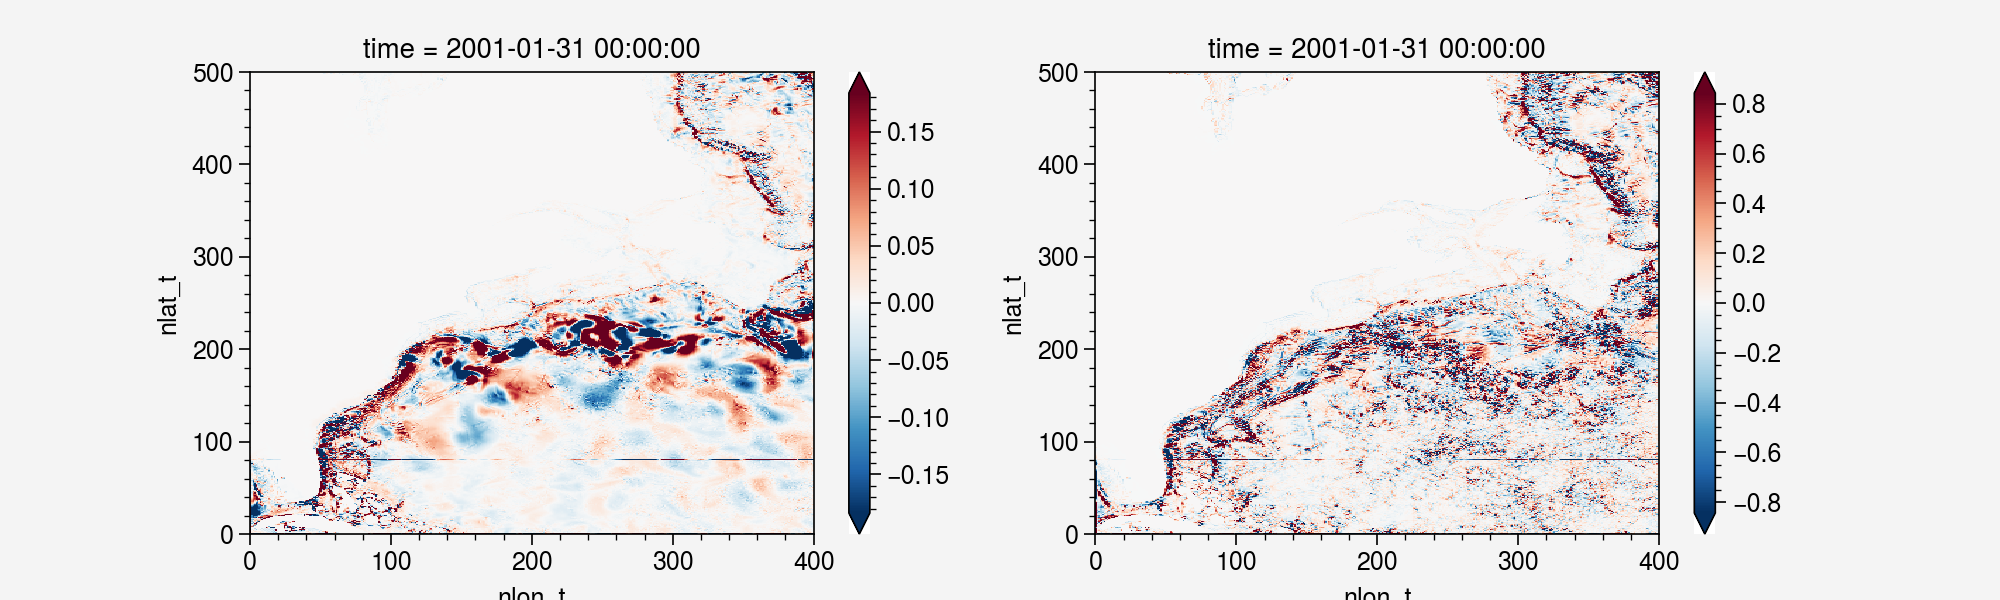

In [17]:
# hdivt_mfl_intz_r_TH = (hdivt_mfl_r_TH*xds_uvel_r_TH.DZT).sum('z_t') # [degC/s*cm]
# hdivt_mfl_intz_r_TH
# hdivs_mfl_intz_r_TH = (hdivs_mfl_r_TH*xds_uvel_r_TH.DZT).sum('z_t') # [psu/s*cm]
# hdivs_mfl_intz_r_TH
hdivt_mfl_intz_r_TH = (hdivt_mfl_r_TH*xds_r_TH.DZT).sum('z_t') # [degC/s*cm]
hdivt_mfl_intz_r_TH
hdivs_mfl_intz_r_TH = (hdivs_mfl_r_TH*xds_r_TH.DZT).sum('z_t') # [psu/s*cm]
hdivs_mfl_intz_r_TH

fig, axs = plt.subplots(1,2,figsize=(10,3))
hdivt_mfl_intz_r_TH.isel(time=0).plot(ax=axs[0], robust=True)
hdivs_mfl_intz_r_TH.isel(time=0).plot(ax=axs[1], robust=True)

# save outputs

In [18]:
%%time
outdir = ('/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/test/')
# save yearly data to a file, dask stop responding if outputs more years to a file (possibly due to one worker concatenates too many time)
# for iyr in np.arange(2001,2021):
# for iyr in np.arange(2081,2101):
for iyr in np.arange(2046,2081):
    print('work on '+ str(iyr))
    yr1_str = str(iyr)+'01'
    yr2_str = str(iyr)+'12'
    hdivt_mfl_intz_r_TH.sel(time=slice(yr1_str,yr2_str)).to_netcdf(path=(outdir+'meanflow_heat_flux_HR_US_'+str(iyr)+'_2022Jan24.nc'), 
                                                             mode='w', 
                                                             format='NETCDF4', 
                                                             compute=True)
    hdivs_mfl_intz_r_TH.sel(time=slice(yr1_str,yr2_str)).to_netcdf(path=(outdir+'meanflow_salt_flux_HR_US_'+str(iyr)+'_2022Jan24.nc'), 
                                                             mode='w', 
                                                             format='NETCDF4', 
                                                             compute=True)

work on 2046
work on 2047
work on 2048
work on 2049
work on 2050
work on 2051
work on 2052
work on 2053
work on 2054
work on 2055
work on 2056
work on 2057
work on 2058
work on 2059
work on 2060
work on 2061
work on 2062
work on 2063
work on 2064
work on 2065
work on 2066
work on 2067
work on 2068
work on 2069
work on 2070
work on 2071
work on 2072
work on 2073
work on 2074
work on 2075
work on 2076
work on 2077
work on 2078
work on 2079
work on 2080
CPU times: user 16.3 s, sys: 5.59 s, total: 21.9 s
Wall time: 14min 43s


In [19]:
# %%time
# hdivs_mfl_intz_r_TH.sel(time=slice('2021','2040')).to_netcdf(path=(outdir+'meanflow_salt_flux_HR_US_202101_204012_2022Jan24.nc'), 
#                                                              mode='w', 
#                                                              format='NETCDF4', 
#                                                              compute=True)
# hdivt_mfl_intz_r_TH.sel(time=slice('2021','2040')).to_netcdf(path=(outdir+'meanflow_heat_flux_HR_US_202101_204012_2022Jan24.nc'), 
#                                                              mode='w', 
#                                                              format='NETCDF4', 
#                                                              compute=True)

In [23]:
# %%time
# outdir = ('/scratch/user/dapengli/Projects4iHESP/Project_SeaLevelUSEastCoast_2021Mar30/data_after_manipulation/test/')

# hdivt_mfl_intz_r_TH.to_netcdf(path=(outdir+'meanflow_heat_flux_HR_US_200101_210012_2022Jan24.nc'), 
#                                                              mode='w', 
#                                                              format='NETCDF4', 
#                                                              compute=True)

# Appendix